# Extracting Pubmed abstracts by scripting NCBI E-utilities in Python

Here, I will show you how NCBI E-Utilities can be used to search for and download Pubmed abstracts. I use Python in conjunction with the NCBI E-Utilities in order to download all the abstracts corresponding to a given search term and simultaneously parse the information contained in each abstract into a data science-friendly format.

## Introduction

Depending on what you search for in PubMed, you could be presented with thousands of abstracts that contain the keyword you used for your query (for example, try searching "cancer"). Finding the information you’re looking for can get a bit tedious when you have to manually click through each page of search results.

Using the NCBI E-Utilities (Entrez Programming Utilities, https://www.ncbi.nlm.nih.gov/books/NBK25499/), you can retrieve and download abstracts associated with a PubMed search without having to sift through the user interface. Even better, this tool doesn’t require any software–its completely URL based. You craft "search" and "fetch" commands as URLs and open them in your browser window to access the abstracts.

We can automate the download process by programming a script in Python to construct the URLs, execute the "search" and "fetch" commands, and parse each part of the abstract (Authors, Journal, Date of publication, etc.) into a data file for downstream analysis. Text from each abstract can be analyzed to quickly extract numerical data or quantitative results.

Below, I will give a brief tutorial about how the tools work, and the code needed to automate the process using Python.

## How the tools work:

The two main E-util functions you will use are ```esearch``` and ```efetch```.

First, ```esearch``` runs a keyword search command on the PubMed database and retrieves IDs for each of the abstracts corresponding to the search. The actual information associated with the abstracts does not show up, only the IDs. You’re also given a ```query key``` and ```web environment ID```. 

Then, you input the ```query key``` and ```web environment ID``` into an ```efetch``` call, which will “fetch” all the abstracts for that specific ```esearch``` query.

Let’s say I want to search pubmed for "P2RY8", which is a receptor on B lymphocytes that I worked on during my PhD.

### Step 1. Craft your esearch URL

Here is the URL required to execute a PubMed esearch for P2RY8:
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=P2RY8&retmax=50&usehistory=y

This was crafted by putting the following parameters together:
* ```http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?``` is the backbone of the esearch function.
* ```db=pubmed``` specifies that we will be searching the pubmed database. 
* ```term=P2RY8``` specifies what we will be searching pubmed for. Change this field to whatever you want to search for.
* ```retmax=50``` specifies how many abstracts I want to return using the search.
* ```usehistory=y``` will provide you with a QueryKey and WebEnv id that will let you fetch abstracts from this search.
* The “&” signs are just used to separate the different conditions. Make sure to include it starting from after the ```db=pubmed``` argument.

Copying and pasting the full URL into my web browser results in a webpage that looks like this (XML output):

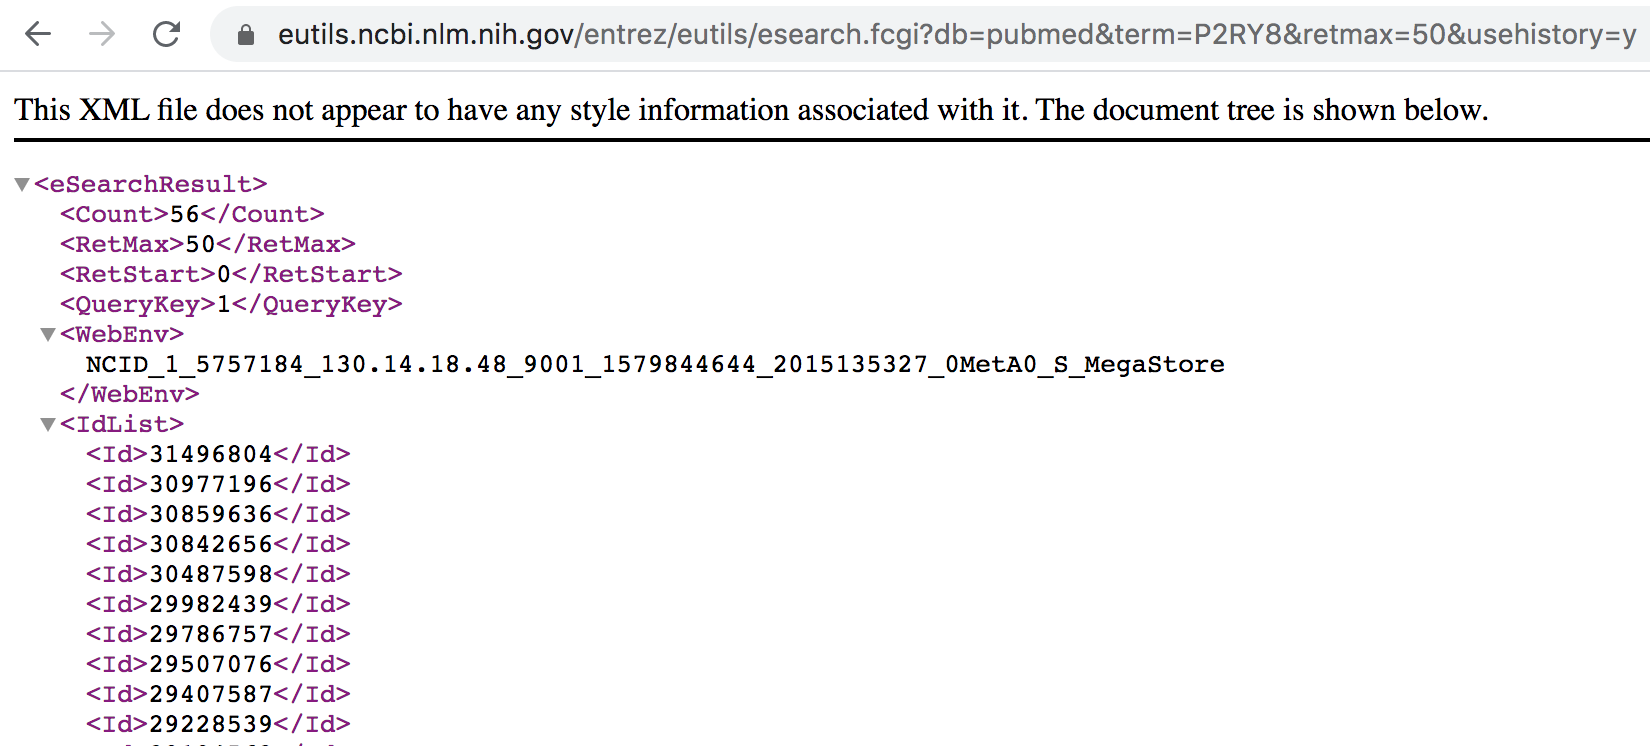

### Step 2. Craft the efetch URL

The next step is to execute an efetch command by constructing a new URL. Using the webenv and querykey information given in the above esearch result, I will type the following efetch command into my browser:

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_5757184_130.14.18.48_9001_1579844644_2015135327_0MetA0_S_MegaStore&retstart=0&retmax=50&retmode=text&rettype=abstract

Note: If you’re trying this right now, your esearch will have given you a different webenv variable. Make sure to input YOUR webenv variable in the efetch URL for it to work!

Here is an explanation for each aspect of the link I constructed above:
* ```http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?``` is the backbone for a efetch command. Notice that the only difference from this and an esearch command is the part after “/eutils/”.
* ```db=pubmed``` specifies the database, again.
* ```query_key=1``` specifies the number that was given in the “querykey” field in the esearch result.
* ```webenv=NCID_1_5757184_130.14.18.48_9001_1579844644_2015135327_0MetA0_S_MegaStore``` specifies the ID that was given in the esearch result. 
* ```retmode=text``` specifies that I want the abstracts to be written out in print. 
* ```rettype=abstract``` specifies that I want abstracts shown, as opposed to other types of info that can be given from a PubMed search.

After inputting this link, you should observe the following output as a plaintext webpage:

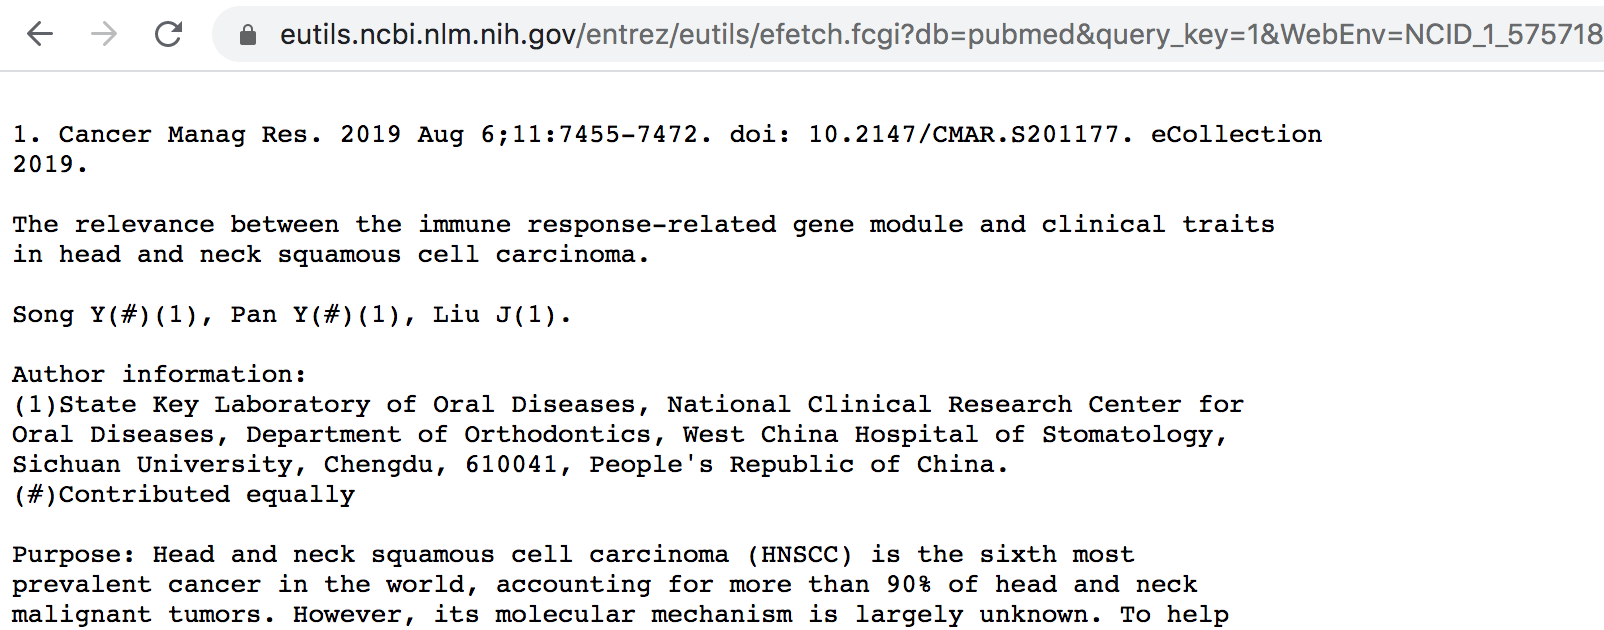

Now, I can simply ctrl-F to sift through over three hundred abstracts. You can apply this simple two-step process whenever you’re tasked with searching through absurd amounts of Pubmed results.

Below, I show you how to perform this process in Python.

## Using the tools in Python

In [11]:
import csv
import re
import urllib
import os
from time import sleep

In [2]:
query = 'P2RY8'

In [4]:
# common settings between esearch and efetch
base_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
db = 'db=pubmed'

# esearch specific settings
search_eutil = 'esearch.fcgi?'
search_term = '&term=' + query
search_usehistory = '&usehistory=y'
search_rettype = '&rettype=json'

search_url = base_url+search_eutil+db+search_term+search_usehistory+search_rettype


In [5]:
print(search_url)

http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=P2RY8&usehistory=y&rettype=json


In [6]:
f = urllib.request.urlopen (search_url)
search_data = f.read().decode('utf-8')

In [7]:
search_data

'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE eSearchResult PUBLIC "-//NLM//DTD esearch 20060628//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20060628/esearch.dtd">\n<eSearchResult><Count>56</Count><RetMax>20</RetMax><RetStart>0</RetStart><QueryKey>1</QueryKey><WebEnv>NCID_1_5579798_130.14.18.48_9001_1579842017_1501765481_0MetA0_S_MegaStore</WebEnv><IdList>\n<Id>31496804</Id>\n<Id>30977196</Id>\n<Id>30859636</Id>\n<Id>30842656</Id>\n<Id>30487598</Id>\n<Id>29982439</Id>\n<Id>29786757</Id>\n<Id>29507076</Id>\n<Id>29407587</Id>\n<Id>29228539</Id>\n<Id>29194562</Id>\n<Id>29140408</Id>\n<Id>28866095</Id>\n<Id>28597942</Id>\n<Id>28408464</Id>\n<Id>28395118</Id>\n<Id>28371317</Id>\n<Id>28033648</Id>\n<Id>27959929</Id>\n<Id>27899802</Id>\n</IdList><TranslationSet/><TranslationStack>   <TermSet>    <Term>P2RY8[All Fields]</Term>    <Field>All Fields</Field>    <Count>56</Count>    <Explode>N</Explode>   </TermSet>   <OP>GROUP</OP>  </TranslationStack><QueryTranslation>P2RY8[All Fields

In [8]:
total_abstract_count = int(re.findall("<Count>(\d+?)</Count>",search_data)[0])

# obtain webenv and querykey settings for efetch command
fetch_webenv = "&WebEnv=" + re.findall ("<WebEnv>(\S+)<\/WebEnv>", search_data)[0]
fetch_querykey = "&query_key=" + re.findall("<QueryKey>(\d+?)</QueryKey>",search_data)[0]

In [13]:
total_abstract_count

56

In [14]:
fetch_webenv

'&WebEnv=NCID_1_5579798_130.14.18.48_9001_1579842017_1501765481_0MetA0_S_MegaStore'

In [15]:
fetch_querykey

'&query_key=1'

In [18]:
# other efetch settings
fetch_eutil = 'efetch.fcgi?'
retmax = 50
retstart = 0
fetch_retstart = "&retstart=" + str(retstart)
fetch_retmax = "&retmax=" + str(retmax)
fetch_retmode = "&retmode=text"
fetch_rettype = "&rettype=abstract"

fetch_url = base_url+fetch_eutil+db+fetch_querykey+fetch_webenv+fetch_retstart+fetch_retmax+fetch_retmode+fetch_rettype
print(fetch_url)

http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_5579798_130.14.18.48_9001_1579842017_1501765481_0MetA0_S_MegaStore&retstart=0&retmax=50&retmode=text&rettype=abstract


In [3]:
f = urllib.request.urlopen (fetch_url)
fetch_data = f.read().decode('utf-8')

NameError: name 'urllib' is not defined

Examining the text output, we see that individual abstracts are separated by 3 new lines (```\n\n\n```). We can therefore use split() to generate a list in which each item is a separate abstract.

In [2]:
abstracts = fetch_data.split("\n\n\n")

NameError: name 'fetch_data' is not defined

In [29]:
len(abstracts)

50

We confirm that there are indeed 50 abstracts.

In [1]:
chunks[1]

NameError: name 'chunks' is not defined

In [43]:
test_abstract = chunks[1]

In [44]:
test_abstract

'2. Immunol Rev. 2019 May;289(1):158-172. doi: 10.1111/imr.12743.\n\nG-protein coupled receptors and ligands that organize humoral immune responses.\n\nLu E(1), Cyster JG(1).\n\nAuthor information: \n(1)Howard Hughes Medical Institute and Department of Microbiology and Immunology,\nUniversity of California San Francisco, San Francisco, California.\n\nB-cell responses are dynamic processes that depend on multiple types of\ninteractions. Rare antigen-specific B cells must encounter antigen and\nspecialized systems are needed-unique to each lymphoid tissue type-to ensure this\nhappens efficiently. Lymphoid tissue barrier cells act to ensure that pathogens, \nwhile being permitted entry for B-cell recognition, are blocked from replication \nor dissemination. T follicular helper (Tfh) cells often need to be primed by\ndendritic cells before supporting B-cell responses. For most responses,\nantigen-specific helper T cells and B cells need to interact, first to initiate\nclonal expansion and 

We observe that the sections of the abstract are separated by 2 new lines in a row (```\n\n```). We can again use split() to further categorize each section of the abstract.

In [45]:
split_abstract = test_abstract.split("\n\n")

Knowing this, we can construct a data frame in which each row represents an abstract, and each column represents a section of the abstract (journal, date, authors, etc.)

There were 56 total abstracts corresponding to the keyword search P2RY8. We have only processed the first 20. In order to obtain all of the abstracts, we can construct a loop that will call ```efetch``` while incrementing ```retstart``` by 20 each iteration, until all the abstracts have been downloaded and added to the table.

In [16]:
query = "P2RY8"

# common settings between esearch and efetch
base_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
db = 'db=pubmed'

# esearch settings
search_eutil = 'esearch.fcgi?'
search_term = '&term=' + query
search_usehistory = '&usehistory=y'
search_rettype = '&rettype=json'

search_url = base_url+search_eutil+db+search_term+search_usehistory+search_rettype
print(search_url)
f = urllib.request.urlopen (search_url)
search_data = f.read().decode('utf-8')
    
total_abstract_count = int(re.findall("<Count>(\d+?)</Count>",search_data)[0])

# efetch settings
fetch_eutil = 'efetch.fcgi?'
retmax = 25
retstart = 0
fetch_retmode = "&retmode=text"
fetch_rettype = "&rettype=abstract"
# obtain webenv and querykey settings from the esearch results
fetch_webenv = "&WebEnv=" + re.findall ("<WebEnv>(\S+)<\/WebEnv>", search_data)[0]
fetch_querykey = "&query_key=" + re.findall("<QueryKey>(\d+?)</QueryKey>",search_data)[0]


run = True
all_abstracts = list()
loop_counter = 1
while run:
    print("this is run number " + str(loop_counter))
    loop_counter += 1

    fetch_retstart = "&retstart=" + str(retstart)
    fetch_retmax = "&retmax=" + str(retmax)
    
    fetch_url = base_url+fetch_eutil+db+fetch_querykey+fetch_webenv+fetch_retstart+fetch_retmax+fetch_retmode+fetch_rettype
    print(fetch_url)
    sleep(2)
    
    f = urllib.request.urlopen (fetch_url)
    fetch_data = f.read().decode('utf-8')
    
    abstracts = fetch_data.split("\n\n\n")
    
    all_abstracts = all_abstracts+abstracts
    
    sleep(2)
    retstart = retstart + retmax
    if retstart > total_abstract_count:
        run = False
    
    

http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=P2RY8&usehistory=y&rettype=json
this is run number 1
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_75523455_130.14.22.33_9001_1580020945_657320164_0MetA0_S_MegaStore&retstart=0&retmax=25&retmode=text&rettype=abstract
this is run number 2
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_75523455_130.14.22.33_9001_1580020945_657320164_0MetA0_S_MegaStore&retstart=25&retmax=25&retmode=text&rettype=abstract
this is run number 3
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=NCID_1_75523455_130.14.22.33_9001_1580020945_657320164_0MetA0_S_MegaStore&retstart=50&retmax=25&retmode=text&rettype=abstract


In [14]:
len(all_abstracts)

56

### References
Sayers E. The E-utilities In-Depth: Parameters, Syntax and More. 2009 May 29. In: Entrez Programming Utilities Help. Bethesda (MD): National Center for Biotechnology Information (US); 2010-.Available from: http://www.ncbi.nlm.nih.gov/books/NBK25499/